# Alberi di derivazione

In [2]:
from liblet import Tree, Grammar, Derivation, ProductionGraph, side_by_side

In [10]:
# più derivazioni, ma un solo parse tree: nessuna ambiguità

G0 = Grammar.from_string("""
S -> A B
A -> a
B -> b
""")

d0_steps = ((0, 0), (1, 0), (2, 1))
d1_steps = ((0, 0), (2, 1), (1, 0))

In [11]:
# queste funzioni, data una grammatica e i passi di una derivazione, la costruiscono

def derivation_from_steps(G, steps): # usando steps
    d = Derivation(G)
    for prod, pos in steps: d = d.step(prod, pos)
    return d

def derivation_from_leftmost(G, prods):
    d = Derivation(G)
    for prod in prods: d = d.leftmost(prod)
    return d

def derivation_from_rightmost(G, prods):
    d = Derivation(G)
    for prod in prods: d = d.rightmost(prod)
    return d

In [19]:
d0 = derivation_from_steps(G0, d0_steps)
d1 = derivation_from_steps(G0, d1_steps)

d0, d1 # le due derivazioni diverse

(S -> A B -> a B -> a b, S -> A B -> A b -> a b)

In [21]:
# ma sostanzialmente lo stesso production graph

side_by_side(ProductionGraph(d0), ProductionGraph(d1))

In [14]:
# costruzione del parse tree a partire da una derivazione

## Dalle derivazioni al parse tree

In [26]:
# costruzione di un parse tree in cui ogni nodo interno è dato dalla coppia (X, n)
# dove X è un non terminale e n è il numero di produzione a cui il nodo si riferisce

def parsetree_from_derivation(d):
    root = [d.G.S]
    sentence = (root, )
    for prod, pos in d.steps():
        tree = sentence[pos]
        children = tuple([X] for X in G.P[prod].rhs)
        tree[0] = (tree[0], prod)
        tree.extend(children)
        sentence = sentence[:pos] + children + sentence[pos + 1:]
    return root

In [29]:
pt0 = parsetree_from_derivation(d0)
pt1 = parsetree_from_derivation(d1)

side_by_side(Tree.from_lol(pt0), Tree.from_lol(pt1))

## Dal parse tree alle derivazioni left/right-most

In [30]:
# la derivazione leftmost si ottiene da una visita

def leftmost_from_parsetree(tree):
    result = []
    def visit(node):
        root, *children = node
        if len(root) == 2: result.append(root[1])
        for child in children: visit(child)
    visit(tree)
    return result

def rightmost_from_parsetree(tree):
    result = []
    def visit(node):
        root, *children = node
        if len(root) == 2: result.append(root[1])
        for child in reversed(children): visit(child)
    visit(tree)
    return result
        
leftmost_from_parsetree(pt0), rightmost_from_parsetree(pt0)

([0, 1, 2], [0, 2, 1])

# Ambiguita'

In [38]:
# un caso di ambiguità "sostanziale"

G1 = Grammar.from_string("""
E -> M | A | n
M -> E * E
A -> E + E
""")

ma_leftmost = 0, 3, 2, 1, 4, 2, 2
am_leftmost = 1, 4, 0, 3, 2, 2, 2

ma = derivation_from_leftmost(G1, ma_leftmost)
am = derivation_from_leftmost(G1, am_leftmost)

ma, am # diverse, ma producono la stessa parola 'n*n+n'

(E -> M -> E * E -> n * E -> n * A -> n * E + E -> n * n + E -> n * n + n,
 E -> A -> E + E -> M + E -> E * E + E -> n * E + E -> n * n + E -> n * n + n)

In [39]:
side_by_side(
    Tree.from_lol(parsetree_from_derivation(ma)),
    Tree.from_lol(parsetree_from_derivation(am))
)

# ε produzioni

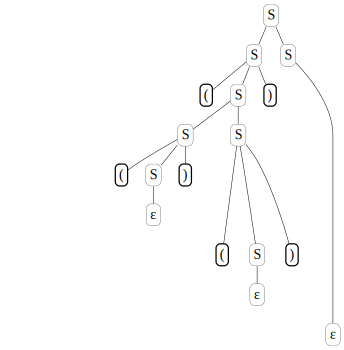

In [42]:
# https://en.wikipedia.org/wiki/Dyck_language

G2 = Grammar.from_string("""
S -> S S | ( S ) | ε
""")
dd_leftmost = 0, 1, 0, 1, 2, 1, 2, 2

dd = derivation_from_leftmost(G2, dd_leftmost)
ProductionGraph(dd) # parola '(()())'

## Aggiustare la trasformazione da derivazione a parse tree

In [45]:
# come si aggiusta parsetree_from_derivation con le ε produzioni?
Tree.from_lol(parsetree_from_derivation(dd))

IndexError: tuple index out of range

## Determinare gli annullabili

In [24]:
from liblet import closure

@closure
def nullable(S, G):
    return S | {lhs for lhs, rhs in G.P if set(rhs) <= S}

nullable({lhs for lhs, rhs in G.P if rhs == ('ε', )}, G)

{'E', 'Q', 'T'}